Jupyter notebook which reads in .Spe data files generated by Maestro software programme. It reads a foreground data file, a background data file and subtracts the background data from the foreground data. It plots the foreground data, background data and background subtracted data and saves the graph in a pdf file.
This script also caluclates the gross and net integrals of a peak or region of interest.
If a linear energy calibration is available, it will replot the spectra as a function of energy. 

Step 1: Import various program modules

Step 2: Input input and output filenames (Before running, upload your foreground and background data files to your Jupyter working directory)

Step 3: read foreground and background data files

Step 4: Define, initialise and fill the working variables

Step 5: Plot the foreground, background and background-subtracted spectra in channel space

Step 6: Define a peak region of interest, fit a linear background, and caluculate the gross and net integrals 

Step 7: Add region of interest to graph and replot

Step 8: Add energy calibration and replot spectra as a function of energy

In [1]:
# import modules

import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as plb
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [2]:
# choose the names of the input and output data filenames

inputfile1   = "second_measurement_cs137_600s.Spe"           # Data filename for foreground data
inputfile2   = "second_measurement_background_600s.Spe"     # Data filename for background data
nochannels   = 512                    # Number of channels in the spectrum (usually 512 or 8192)
outputfile1  = 'MaestroSpectrum1.pdf' # Data filename for output graph in channels
outputfile2  = 'MaestroSpectrum2.pdf' # Data filename for output graph in channels showing region of interest
outputfile3  = 'MaestroSpectrum3.pdf' # Data filename for output graph in energy showing region of interest

In [3]:
# read foreground and background data files

with open(inputfile1,'r') as filehandle:  
    filecontent1 = filehandle.readlines()
with open(inputfile2,'r') as filehandle:  
    filecontent2 = filehandle.readlines()          

In [4]:
# define arrays for channels, energy, foreground, background and background subtracted counts

channel = np.array([ x + 1 for x in range(nochannels) ],'i')
energy  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield1  = np.array([ x + 1 for x in range(nochannels) ],'i')
error1  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield2  = np.array([ x + 1 for x in range(nochannels) ],'i')
error2  = np.array([ x + 1 for x in range(nochannels) ],'f')
yield3  = np.array([ x + 1 for x in range(nochannels) ],'i')
error3  = np.array([ x + 1 for x in range(nochannels) ],'f')

# fill the arrays yield1, yield2 and yield3 with data from foreground and background 
# data files and the background subtracted data. The subtraction assumes that the foreground and 
# background data were taken for the same period of time.

count = 0
while count < nochannels:
    count2 = count + 12                                          # Data in .Spe files start from line 12
    yield1[count] = int(filecontent1[count2])                    # foreground data
    yield2[count] = int(filecontent2[count2])                    # background data
    yield3[count] = int(yield1[count]-yield2[count])             # background-subtracted data
    error1[count] = math.sqrt(yield1[count])                     # Poisson errors in foreground data
    error2[count] = math.sqrt(yield2[count])                     # Poisson errors in background data
    error3[count] = math.sqrt(yield1[count]+yield2[count])       # errors in background-subtracted data
    count += 1     

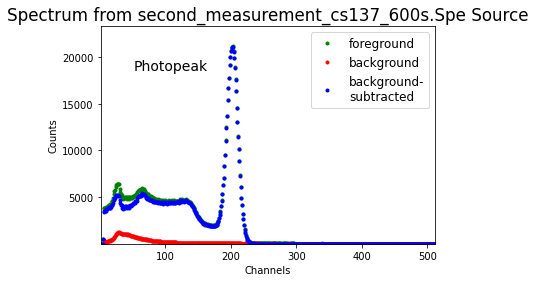

In [5]:
# Plot the foreground, background and background-subtracted spectra in channel space

#set parameters for the graph

figuretitle   = 'Spectrum from '+ inputfile1 + ' Source'  # set title for the graph
xlabeltext    = "Channels"                                # set x-axis label
ylabeltext    = "Counts"                                  # set y-axis label
annotatetext1 = "Photopeak"                               # set text for annotation 1
yaxistype     = "linear"                                  # choose 'log' or 'linear' for yscale

# select plotting symbols

symbol1='g.'       # choose colour and symbol for foreground data points ('r.', 'go', 'bD', etc.)
symbol2='r.'       # choose colour and symbol for background data points 
symbol3='b.'       # choose colour and symbol for subtracted data points 

# find minimum and maximum x- and y-values in the data to be plotted

xcountsmin=min(channel)
xcountsmax=max(channel)
ycountsmin=min(yield1)
ycountsmax=max(yield1)

# set minimum and maximum scales for x- and y-axes

xplotmin=xcountsmin
xplotmax=xcountsmax
yplotmin=0.1                  # set non-zero value to avoid error if logarithmic y-axis chosen
yplotmax=ycountsmax*1.1

# set location for annotation

annotatexposition1 = xplotmin+0.1*(xplotmax-xplotmin) # use fraction between 0 and 1 to ensure position is within plot area
annotateyposition1 = yplotmin+0.8*(yplotmax-yplotmin) # use fraction between 0 and 1 to ensure position is within plot area

# plot and save the graph

plt.yscale(yaxistype)                                                   # plot 'log' or 'linear' for yscale
plt.rcParams["figure.figsize"] = (8,6)                                  # set figure size (x,y) in inches
plt.rcParams['font.family'] = 'DejaVu Sans'                             # set font style for labels 
plt.rcParams['font.size'] = 14                                          # set font size for labels
plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                      # plot the graph axes
plt.xlabel(xlabeltext)                                                  # add label for x-axis
plt.ylabel(ylabeltext)                                                  # add label for y-axis
plt.title(figuretitle)                                                  # add figure title
plt.plot(channel,yield1,symbol1,label="foreground")                     # plot foreground data
plt.plot(channel,yield2,symbol2,label="background")                     # plot background data
plt.plot(channel,yield3,symbol3,label="background-\nsubtracted")        # plot background-subtracted data
plt.legend(loc=1,prop={'size': 12})                                     # add legend to plot, locate upper right
plt.annotate(annotatetext1,xy=(annotatexposition1,annotateyposition1))  # Sample annotation of graph
plt.savefig(outputfile1,bbox_inches = 'tight')                          # write out spectra to outputfile
plt.show()

In [9]:
# Integrate a peak or other region of interest.
# Gross integral is the total number of counts in region of interest.
# Net integral subtracts off a linear background.

xlower = 180                  # set lower channel of region of interest
xupper = 225                  # set upper channel of interest

# calculate integrals

ylower = yield3[xlower]
yupper = yield3[xupper]
grossintegral= 0
x=xlower
while x < xupper:
    grossintegral=grossintegral+yield3[x]
    x=x+1

grossintegralerror = int(math.sqrt(grossintegral))    
netintegral = int(grossintegral - (xupper-xlower)*0.5*(ylower+yupper)) 
netintegralerror = int(math.sqrt(netintegral))

print("Gross integral from channel",xlower,"to",xupper,"is",grossintegral,u"\u00B1",grossintegralerror)
print("Net   integral from channel",xlower,"to",xupper,"is",netintegral,u"\u00B1",netintegralerror)

Gross integral from channel 180 to 225 is 452727 ± 672
Net   integral from channel 180 to 225 is 391054 ± 625


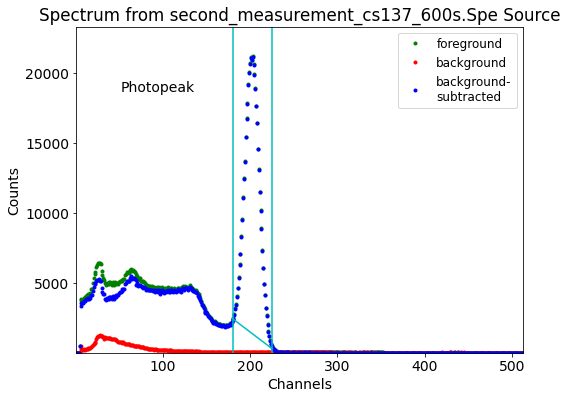

In [10]:
# add region of interest to graph and replot

figuretitle   = 'Spectrum from '+ inputfile1 + ' Source'  # set title for the graph
xlabeltext    = "Channels"                                # set x-axis label
ylabeltext    = "Counts"                                  # set y-axis label
annotatetext1 = "Photopeak"                               # set text for annotation 1
yaxistype     = "linear"                                  # choose 'log' or 'linear' for yscale

# select plotting symbols

symbol1='g.'       # choose colour and symbol for foreground data points ('r.', 'go', 'bD', etc.)
symbol2='r.'       # choose colour and symbol for background data points 
symbol3='b.'       # choose colour and symbol for subtracted data points 

# find minimum and maximum x- and y-values in the data to be plotted

xcountsmin=min(channel)
xcountsmax=max(channel)
ycountsmin=min(yield1)
ycountsmax=max(yield1)

# set minimum and maximum scales for x- and y-axes

xplotmin=xcountsmin
xplotmax=xcountsmax
yplotmin=0.1                  # set non-zero value to avoid error if logarithmic y-axis chosen
yplotmax=ycountsmax*1.1

# set location for annotation

annotatexposition1 = xplotmin+0.1*(xplotmax-xplotmin) # use fraction between 0 and 1 to ensure position is within plot area
annotateyposition1 = yplotmin+0.8*(yplotmax-yplotmin) # use fraction between 0 and 1 to ensure position is within plot area

# plot and save the graph

plt.yscale(yaxistype)                                                   # plot 'log' or 'linear' for yscale
plt.rcParams["figure.figsize"] = (8,6)                                  # set figure size (x,y) in inches
plt.rcParams['font.family'] = 'DejaVu Sans'                             # set font style for labels 
plt.rcParams['font.size'] = 14                                          # set font size for labels
plt.axis([xplotmin, xplotmax, yplotmin, yplotmax])                      # plot the graph axes
plt.xlabel(xlabeltext)                                                  # add label for x-axis
plt.ylabel(ylabeltext)                                                  # add label for y-axis
plt.title(figuretitle)                                                  # add figure title
plt.plot(channel,yield1,symbol1,label="foreground")                     # plot foreground data
plt.plot(channel,yield2,symbol2,label="background")                     # plot background data
plt.plot(channel,yield3,symbol3,label="background-\nsubtracted")        # plot background-subtracted data
plt.legend(loc=1,prop={'size': 12})                                     # add legend to plot, locate upper right
plt.plot([xlower,xlower],[yplotmin,yplotmax],'-c')                      # add lower limit of region of interest
plt.plot([xupper,xupper],[yplotmin,yplotmax],'-c')                      # add upper limit of region of interest
plt.plot([xlower,xupper],[ylower,yupper],'-c')                          # add linear background line
plt.annotate(annotatetext1,xy=(annotatexposition1,annotateyposition1))  # Sample annotation of graph
plt.savefig(outputfile2,bbox_inches = 'tight')                          # write out spectra to outputfile
plt.show()

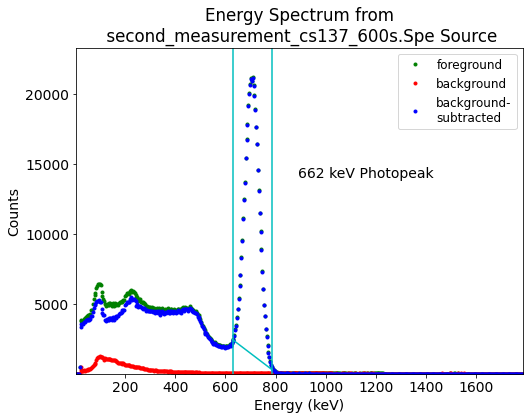

In [11]:
# add energy calibration

calibrationgradient = 3.48   # units of keV/channel 
calibrationoffset   = 2      # units of keV

# convert x-data from channels to energy

x=0
while x < nochannels:
    energy[x]=channel[x]*calibrationgradient + calibrationoffset
    x=x+1
    
xplotmine=xcountsmin*calibrationgradient + calibrationoffset
xplotmaxe=xcountsmax*calibrationgradient + calibrationoffset

xlowere = xlower*calibrationgradient + calibrationoffset
xuppere = xupper*calibrationgradient + calibrationoffset

# Plot the energy spectra

figuretitle   = 'Energy Spectrum from\n '+ inputfile1 + ' Source'  # set title for the graph
xlabeltext    = "Energy (keV)"                                    # set x-axis label
ylabeltext    = "Counts"                                          # set y-axis label
annotate1text = "662 keV Photopeak"                               # set text for annotation 1
plt.yscale('linear')                                              # choose 'log' or 'linear' for yscale
plt.rcParams["figure.figsize"] = (8,6)                            # set figure size (x,y) in inches
plt.rcParams['font.family'] = 'DejaVu Sans'                       # set font style for labels 
plt.rcParams['font.size'] = 14                                    # set font size for labels

# set location for annotation

annotate1positionx = xplotmin+0.5*(xplotmaxe-xplotmine) # use fraction between 0 and 1 to ensure position is within plot area
annotate1positiony = yplotmin+0.6*(yplotmax-yplotmin) # use fraction between 0 and 1 to ensure position is within plot area

# select plotting symbols

symbol1='g.'       # choose colour and symbol for foreground data points ('r.', 'go', 'bD', etc.)
symbol2='r.'       # choose colour and symbol for background data points 
symbol3='b.'       # choose colour and symbol for subtracted data points 

# Plot the axes, title and labels

plt.axis([xplotmine, xplotmaxe, yplotmin, yplotmax])                   # plot the graph axes
plt.xlabel(xlabeltext)                                                 # add label for x-axis
plt.ylabel(ylabeltext)                                                 # add label for y-axis
plt.title(figuretitle)                                                 # add figure title
plt.plot(energy,yield1,symbol1,label="foreground")                     # plot foreground data
plt.plot(energy,yield2,symbol2,label="background")                     # plot background data
plt.plot(energy,yield3,symbol3,label="background-\nsubtracted")        # plot background-subtracted data
plt.legend(loc=1,prop={'size': 12})                                    # add legend to plot, locate upper right
plt.plot([xlowere,xlowere],[yplotmin,yplotmax],'-c')                   # add lower limit of region of interest
plt.plot([xuppere,xuppere],[yplotmin,yplotmax],'-c')                   # add lower limit of region of interest
plt.plot([xlowere,xuppere],[ylower,yupper],'-c')                       # add linear background line
plt.annotate(annotate1text,xy=(annotate1positionx,annotate1positiony)) # annotate graph with fitted centroid
plt.savefig(outputfile3,bbox_inches = 'tight')                         # write out spectra to outputfile
plt.show()